# Autoencoder 소개

이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해 autoencoder를 소개합니다.

autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다. 예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 autoencoder는 먼저 이미지를 더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및 Aaron Courville의 [딥 러닝](https://www.deeplearningbook.org/)에서 14장을 읽어보세요.

## TensorFlow 및 기타 라이브러리 가져오기

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## 데이터세트 로드하기

시작하려면 Fashon MNIST 데이터세트를 사용하여 기본 autoencoder를 훈련합니다. 이 데이터세트의 각 이미지는 28x28 픽셀입니다. 

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

## 첫 번째 예: 기본 autoencoder

![기본 오토 인코더 결과](images/intro_autoencoder_result.png)

두 개의 Dense 레이어로 autoencoder를 정의합니다. 이미지를 64차원 잠재 벡터로 압축하는 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`입니다.

모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용하세요.


In [ ]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                             # (1,28,28) => (1,784)
      layers.Dense(latent_dim, activation='relu'),  # (1,784)(784,64) => (1,64)
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),      # (1,64)(64,784) => (1,784)
      layers.Reshape((28, 28))                      # (28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

`x_train`을 입력과 대상으로 사용하여 모델을 훈련합니다. `encoder`는 데이터세트를 784차원에서 잠재 공간으로 압축하는 방법을 배우고, `decoder`는 원본 이미지를 재구성하는 방법을 배웁니다. .

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 두 번째 예: 이미지 노이즈 제거

![이미지 노이즈 제거 결과](images/image_denoise_fmnist_results.png)

autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.

이전에 수정한 내용을 생략하기 위해 데이터세트를 다시 가져오겠습니다.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

이미지에 임의의 노이즈를 추가합니다.

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 있는 이미지를 플롯합니다.


In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 컨볼루셔널 autoencoder 정의하기

이 예제에서는 <code>encoder</code>에 <a>Conv2D</a> 레이어를 사용하고 <code>decoder</code>에 <a>Conv2DTranspose</a> 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련합니다.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),   # (1,14,14,16)
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])   # (1,7,7,8)
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), # (1,14,14,8)
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),# (1,28,28,16)
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')]) # (1,28,28,1)
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

encoder의 요약을 살펴보겠습니다. 이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 확인하세요.

In [ ]:
autoencoder.encoder.summary()

decoder는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.

In [ ]:
autoencoder.decoder.summary()

autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거 된 이미지를 모두 플롯합니다.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 세 번째 예: 이상 감지

## 개요

이 예에서는 [ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

### ECG 데이터 로드하기

사용할 데이터세트는 [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)의 데이터세트를 기반으로 합니다.


In [7]:
# Download the dataset
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [8]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

데이터를 `[0,1]`로 정규화합니다.


In [9]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

이 데이터세트에서 `1`로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다. 정상 리듬과 비정상 리듬을 분리합니다.

In [10]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

정상적인 ECG를 플롯합니다. 

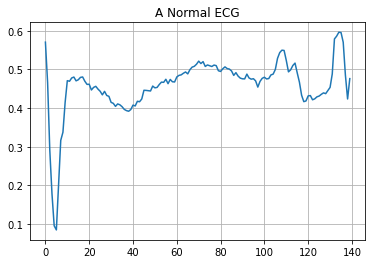

In [11]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

비정상적인 ECG를 플롯합니다.

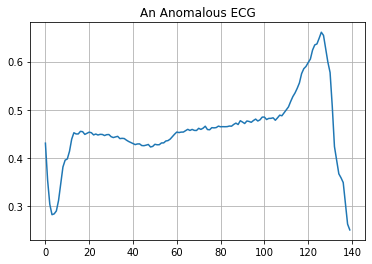

In [12]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 모델 빌드하기

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),  # (1,140)(140,32) => (1,32)
      layers.Dense(16, activation="relu"),  # (1,32)(32,16) => (1,16)
      layers.Dense(8, activation="relu")])  # (1,16)(16,8) => (1,8)
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),  # (1,8)(8,16) => (1,16)
      layers.Dense(32, activation="relu"),  # (1,16)(16,32) => (1,32)
      layers.Dense(140, activation="sigmoid")]) # (1,32)(32,140) => (1,140)
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [14]:
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가됩니다.

In [15]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 181ms/step - loss: 0.0593 - val_loss: 0.0538
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0572 - val_loss: 0.0527
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0560 - val_loss: 0.0516
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 0.0546 - val_loss: 0.0502
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0526 - val_loss: 0.0488
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0501 - val_loss: 0.0474
Epoch 7/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0466 - val_loss: 0.0464
Epoch 8/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0433 - val_loss: 0.0447
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0399 - val_loss: 0.0429
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0364 - val_loss: 0.0415
Epoch 11/20
5/5 [===========

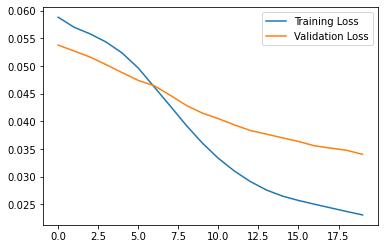

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다. 먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯해 보겠습니다.

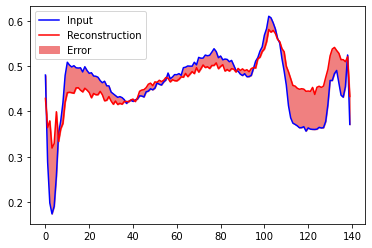

In [17]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.

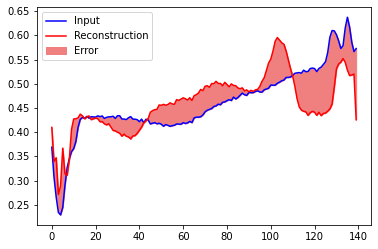

In [18]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 이상 감지하기

재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다. 이 튜토리얼에서는 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음, 재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.


훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

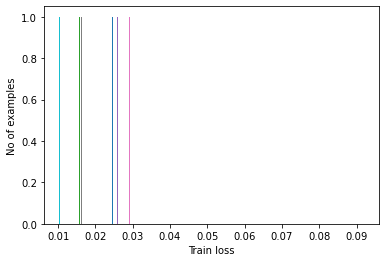

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균보다 표준 편차가 높은 임계값을 선택합니다.

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033746783


참고: 테스트 예제를 이상 항목으로 분류하는 임계값을 선택하는 데 사용할 수 있는 다른 전략이 있습니다. 올바른 접근 방식은 데이터세트에 따라 다릅니다. 이 튜토리얼의 끝에 있는 링크를 통해 더 많은 것을 배울 수 있습니다. 

테스트 세트에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있습니다. 임계값을 변경하여 분류자의 [정밀도](https://developers.google.com/machine-learning/glossary#precision)와 [재현율](https://developers.google.com/machine-learning/glossary#recall)을 조정할 수 있습니다. 

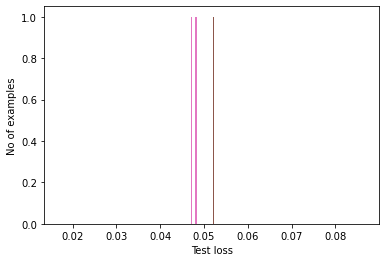

In [21]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

## 다음 단계

autoencoder를 사용한 이상 탐지에 대해 자세히 알아보려면 Victor Dibia가 TensorFlow.js로 빌드한 훌륭한 [대화형 예제](https://anomagram.fastforwardlabs.com/#/)를 확인하세요. 실제 사용 사례의 경우, TensorFlow를 사용하여 [Airbus가 ISS 원격 측정 데이터에서 이상을 감지](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)하는 방법을 알아볼 수 있습니다. 기본 사항에 대해 자세히 알아보려면 François Chollet의 [블로그 게시물](https://blog.keras.io/building-autoencoders-in-keras.html)을 읽어보세요. 자세한 내용은 Ian Goodfellow, Yoshua Bengio, Aaron Courville의 [딥 러닝](https://www.deeplearningbook.org/)에서 14장을 확인하세요.
